# Modeling void fraction in fluid channel using cross-sectional ellipses

This notebook is designed for analysis of neutron data
which describes void fraction of refrigerant
flowing through a microfluidic channel.

Created on Wed April 29 17:07:13 2020  
author: ericmuckley@gmail.com

Full repository can be viewed at  
https://github.com/ericmuckley/fluid_channel_modeling

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import shapely.affinity
from shapely.geometry import LineString, Point, Polygon
from shapely.ops import unary_union

from descartes import PolygonPatch


def plot_channel(image, title=None, vmin=None, vmax=None):
    """Plot image of the channel, colored by void fraction."""
    plt.imshow(image, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, )
    fig = plt.gcf()
    fig.set_size_inches(11,11)
    plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=16)
    plt.show()


## Get images to model

['w_um', 'h_um', 'd_um', 'um_per_pixel', 'buffer_um', 'min_rad_um', 'max_rad_um', 'channels']


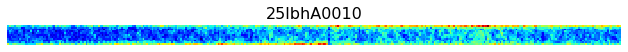

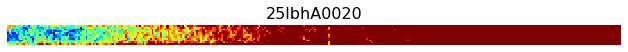

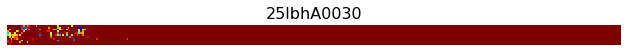

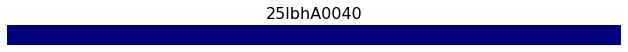

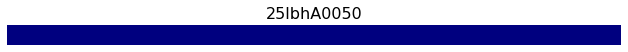

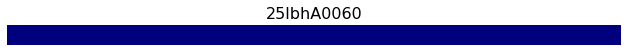

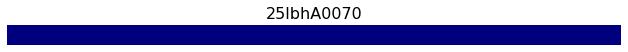

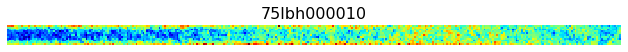

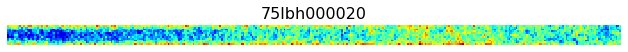

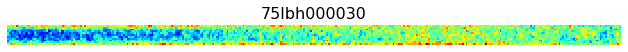

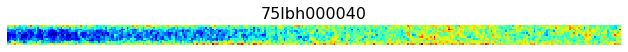

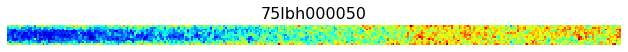

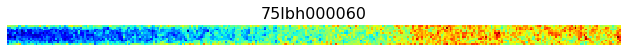

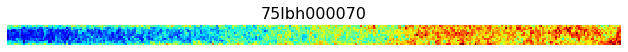

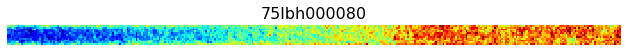

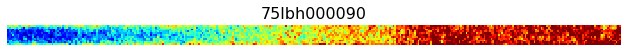

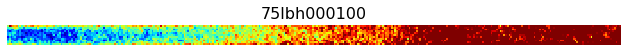

In [2]:
# navigate to data folder
data_path = os.path.join(os.getcwd(), 'data', 'compiled_data.npy')

data = np.load(data_path, allow_pickle=True)[()]
print(list(data))

# loop over each image
for L in data['channels']:
    img = data['channels'][L]['img_voidfrac']
    plot_channel(img, title=L)
    #print(img.shape)
    #print(img.min())
    #print(img.max())

In [12]:
def get_guess(cs, n):
    """
    Get initial guess for fitting void fraction
    profile to multiple ellipsoidal discs. A guess is
    required for multi-peak fitting so that the number of
    fit parameters remained fixed.
    Inputs:
    cs: cross section to fit ([x, y] 2D array)
    n: number of ellipses to fit
    """
    # low and high tolerance factors for each bound
    lo_tol, hi_tol = 0.75, 1.25
    
    # first bubble: main large bubble in center of channel
    guess = [cs['x'].max()/2,
            cs['x'].max()-cs['x'].min(),
            cs['cs'].min()]
    low_bounds = [g*0.95 for g in guess]
    high_bounds = [g*1.05 for g in guess]
    
    # 2nd bubble: 1/4 of the way into channel
    guess.extend([cs['x'].max()/4,
                  (cs['x'].max()-cs['x'].min()-1)/2,
                  cs['cs'].min()/2])
    low_bounds.extend([g*lo_tol for g in guess[3:]])
    high_bounds.extend([g*hi_tol for g in guess[3:]])
    
    # 3rd bubble: 3/4 of the way into channel
    guess.extend([cs['x'].max()*3/4,
                  (cs['x'].max()-cs['x'].min()-1)/2,
                  cs['cs'].min()/2])
    low_bounds.extend([g*lo_tol for g in guess[6:]])
    high_bounds.extend([g*hi_tol for g in guess[6:]])
    
    # 4th and 5th bubbles: near channel edges
    guess.extend([cs['x'].max()/10,
                  (cs['x'].max()-cs['x'].min()-1)/5,
                  cs['cs'].min()/4])
    low_bounds.extend([g*lo_tol for g in guess[9:]])
    high_bounds.extend([g*hi_tol for g in guess[9:]])
    
    guess.extend([cs['x'].max()*9/10,
                  (cs['x'].max()-cs['x'].min()-1)/5,
                  cs['cs'].min()/4])
    low_bounds.extend([g*lo_tol for g in guess[12:]])
    high_bounds.extend([g*hi_tol for g in guess[12:]])

    # 6th bubble: near channel center
    guess.extend([cs['x'].max()/2,
                  (cs['x'].max()-cs['x'].min()-1)/5,
                  cs['cs'].min()/4])
    low_bounds.extend([g*lo_tol for g in guess[15:]])
    high_bounds.extend([g*hi_tol for g in guess[15:]])
    
    # 7th and 8th bubbles: near channel edges
    guess.extend([cs['x'].max()/15,
                  (cs['x'].max()-cs['x'].min()-1)/8,
                  cs['cs'].min()/2])
    low_bounds.extend([g*lo_tol for g in guess[18:]])
    high_bounds.extend([g*hi_tol for g in guess[18:]])
    
    guess.extend([cs['x'].max()*9/10,
                  (cs['x'].max()-cs['x'].min()-1)/8,
                  cs['cs'].min()/2])
    low_bounds.extend([g*lo_tol for g in guess[21:]])
    high_bounds.extend([g*hi_tol for g in guess[21:]])

    
    '''
    print('guess')
    print(np.reshape(guess,((-1, 3))))
    print('low bounds')
    print(np.reshape(low_bounds, (-1, 3)))
    print('high_bounds')
    print(np.reshape(high_bounds, (-1, 3)))
    '''
    return guess, (low_bounds, high_bounds)




## Fit model of multiple elliptical bubbles in channel

ValueError: `x0` is infeasible.

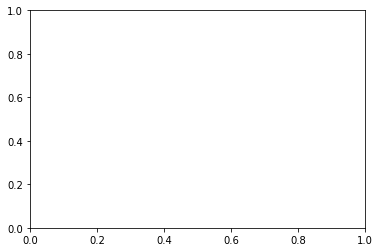

In [19]:
def get_ellipse(properties):
    """
    Get an ellipse object from its properties:
    [x0, y0, rx, ry]
    """
    circle = Point(properties['x0'], properties['y0']).buffer(1)
    ellipse = shapely.affinity.scale(circle, properties['rx'], properties['ry'])
    return ellipse

def overlapping_multi_ellipse_integral(multipolygon, xrange=10, yrange=250):
    """
    This function takes a Shapely multipolygon object
    and integrates over its profile in the x-direction.
    """
    integral = []
    for c in range(int(xrange)):
        grid_points = np.column_stack((np.repeat(c, int(yrange)), np.arange(int(yrange))))
        contains = [union.contains(Point(p)) for p in grid_points]
        integral.append(np.sum(contains))
    return integral

def multiellipse_fit(x, *params):
    """
    Use this function with scipy curve_fit for least sqquares minimization
    of ellipse packing inside a void fraction profile. Input is a list of
    initial fit parameters for the ellipses. Output is the total integral
    over all fitted ellipses.
    """
    global union
    ellipse_list = []
    for i in range(0, len(params), 4):
        # get ellipse from its properties
        circle = Point(params[i], params[i+1]).buffer(1)
        ellipse = shapely.affinity.scale(circle, params[i+2], params[i+3])
        ellipse_list.append(ellipse)
    # get union of all ellipses if they are intersecting
    union = unary_union(ellipse_list)
    # calculate total void fraction fit (integral over all ellipses)
    fit = overlapping_multi_ellipse_integral(union, len(cs['x']), data['d_um'])
    return fit




# loop over each vertical cross section of image
for i in range(1):

    # create dataframe for holding cross section and simulated cross section
    cs = pd.DataFrame(
        np.column_stack((np.arange(img.shape[0]), img[:, i], np.zeros_like(img[:, 0]))),
        columns=['x', 'cs', 'sim'])


    # get fitting parameters
    #bub_num = 40
    #guess = [5, 100, 5, 100,
    #        2, 200, 3, 20,
    #        8, 200, 3, 20]
    guess, bounds = get_guess(cs, 5)

    
    x_to_fit = cs['x']#[-0.1] + list(cs['x']) + [cs['x'].max()+0.1]
    y_to_fit = cs['cs']#[0] + list(cs['cs']) + [0]

    fig, ax = plt.subplots()
    
    popt, pcov = curve_fit(multiellipse_fit, x_to_fit, y_to_fit, p0=guess, method='trf', bounds=bounds)
    
    fit = multiellipse_fit(cs['x'], *popt)
    
    # add union of all ellipses to the plot
    ax.add_patch(PolygonPatch(union, fc='b', ec='b', alpha=0.2))
    # plot measured cross section
    plt.plot(cs['x'], cs['cs'], c='k', label='measured')
    # plot simulated cross section
    plt.plot(cs['x'], fit, c='r', linestyle='--', label='fit')
    fig.set_size_inches(2, 6)
    plt.xlim([0, np.max(cs['x'])])
    plt.ylim([0, data['d_um']])
    plt.legend()
    #plt.tight_layout()
    #plt.xticks([])
    #plt.yticks([])
    plt.title('{}\ncolumn {}'.format(L, i+1))
    #plt.savefig(os.path.join(save_img_dir, 'img_{}.jpg'.format(str(i).zfill(5))))
    plt.show()



In [18]:
guess

[5.0,
 10.0,
 121.56862745098039,
 2.5,
 4.5,
 60.78431372549019,
 7.5,
 4.5,
 60.78431372549019,
 1.0,
 1.8,
 30.392156862745097,
 9.0,
 1.8,
 30.392156862745097,
 5.0,
 1.8,
 30.392156862745097,
 0.6666666666666666,
 1.125,
 60.78431372549019,
 9.0,
 1.125,
 60.78431372549019]

In [ ]:
def get_ellipse(properties):
    """
    Get an ellipse object from its properties:
    [x0, y0, rx, ry]
    """
    circle = Point(properties['x0'], properties['y0']).buffer(1)
    ellipse = shapely.affinity.scale(circle, properties['rx'], properties['ry'])
    return ellipse

def overlapping_multi_ellipse_integral(multipolygon, xrange=10, yrange=250):
    """
    This function takes a Shapely multipolygon object
    and integrates over its profile in the x-direction.
    """
    integral = []
    for c in range(int(xrange)):
        grid_points = np.column_stack((np.repeat(c, int(yrange)), np.arange(int(yrange))))
        contains = [union.contains(Point(p)) for p in grid_points]
        integral.append(np.sum(contains))
    return integral

def multiellipse_fit(x, *params):
    """
    Use this function with scipy curve_fit for least sqquares minimization
    of ellipse packing inside a void fraction profile. Input is a list of
    initial fit parameters for the ellipses. Output is the total integral
    over all fitted ellipses.
    """
    ellipse_list = []
    for i in range(0, len(params), 4):
        # get ellipse from its properties
        circle = Point(params[i], params[i+1]).buffer(1)
        ellipse = shapely.affinity.scale(circle, params[i+2], params[i+3])
        ellipse_list.append(ellipse)
    # get union of all ellipses if they are intersecting
    union = unary_union(ellipse_list)
    # calculate total void fraction fit (integral over all ellipses)
    fit = overlapping_multi_ellipse_integral(union, len(cs['x']), data['d_um'])
    return fit




# loop over each vertical cross section of image
for i in range(1):

    # create dataframe for holding cross section and simulated cross section
    cs = pd.DataFrame(
        np.column_stack((np.arange(img.shape[0]), img[:, i], np.zeros_like(img[:, 0]))),
        columns=['x', 'cs', 'sim'])


    # get fitting parameters
    bub_num = 40
    ellipse_properties = pd.DataFrame(
        (np.random.random((bub_num, 4)))*5, columns=['x0', 'y0', 'rx', 'ry'])
    
    ellipse_properties['x0'] = np.random.randint(1, len(cs['x']-1), size=bub_num)
    ellipse_properties['y0'] = np.random.randint(20, data['d_um']-20, size=bub_num)
    ellipse_properties['rx'] = np.random.randint(1, 5, size=bub_num)
    ellipse_properties['ry'] = np.random.randint(2, 20, size=bub_num)



    ellipse_list = []
    fig, ax = plt.subplots()
    
    # loop over each bubble that we're adding to the channel
    for b in range(len(ellipse_properties)):
        
        # get ellipse from its properties
        ellipse = get_ellipse(dict(ellipse_properties.iloc[b]))
        ellipse_list.append(ellipse)


    # get union of all bubbles if they are intersecting
    union = unary_union(ellipse_list)
    print('total union area: {}'.format(round(union.area, 2)))

    # calculate total void fraction fit (integral over all ellipses)
    fit = overlapping_multi_ellipse_integral(union, len(cs['x']), data['d_um'])
    fit_area = np.trapz(fit, x=np.arange(len(fit)))
    print('total fit area: {}'.format(round(fit_area, 2)))
    
    
    
    # add union of all ellipses to the plot
    ax.add_patch(PolygonPatch(union, fc='b', ec='b', alpha=0.2))
    # plot measured cross section
    plt.plot(cs['x'], cs['cs'], c='k', label='measured')
    # plot simulated cross section
    plt.plot(cs['x'], fit, c='r', linestyle='--', label='fit')
    fig.set_size_inches(2, 6)
    plt.xlim([0, np.max(cs['x'])])
    plt.ylim([0, data['d_um']])
    plt.legend()
    #plt.tight_layout()
    #plt.xticks([])
    #plt.yticks([])
    plt.title('{}\ncolumn {}'.format(L, i+1))
    #plt.savefig(os.path.join(save_img_dir, 'img_{}.jpg'.format(str(i).zfill(5))))
    plt.show()



In [ ]:

'''

def get_multipolygon_coords(multipolygon):
    """
    Get coordinates of the boundaries of a Shapely
    multipolygon (union of polygons) object
    """
    if multipolygon.type == 'Polygon':
        print('single')
    if multipolygon.type == 'MultiPolygon':
        print('multi')
    coords = []
    for p in multipolygon:
        poly_coords = np.array([pp for pp in p.exterior._get_coords()])
        coords.append(poly_coords)
    return coords
        
coords = get_multipolygon_coords(union)

tot_int = 0

for c in coords:
    tot_int += np.trapz(c[:, 1], x=c[:, 0])

print('tot int: {}'.format(tot_int))

for c in coords:
    plt.plot(c[:, 0], c[:, 1], lw=1)
plt.show()
#[np.array([i for i in a.exterior._get_coords()]) for a in union]
'''